In [2]:
# Import all the needed packages
import datetime
import requests
import json
import warnings

import pandas as pd  # type: ignore
from pandas_datareader import data as pdr #read data from yahoo finance api

import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing # type: ignore
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing

from sklearn.metrics import mean_squared_error # accuracy metrics
from sklearn.metrics import mean_absolute_error # accuracy metrics
from sklearn.metrics import mean_absolute_percentage_error # accuracy metrics
from sklearn.metrics import r2_score # accuracy metrics
from sklearn.model_selection import train_test_split

import yfinance as yf
import pmdarima as pm # type: ignore


warnings.filterwarnings('ignore')

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
sales_df = pd.read_csv('./us_ev_sales_2021.1-2024.6.csv', index_col=0)
sales_df['Date'] = sales_df.index
sales_df['Year'] = sales_df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').year)
sales_df['Month'] = sales_df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').month)
sales_df_group = sales_df.groupby(by=['Year', 'Month']).agg({'Daily EV Sales with Noise': 'sum'})
sales_df_group.columns = ['Sales']
indexes = sales_df_group.index
new_indexes = [datetime.datetime(index[0], index[1], 1) for index in indexes]
sales_df_group.index = new_indexes
sales_df_group['Sales'] /= 1000
display(sales_df_group)
# sales_df_group = sales_df.copy()
# sales_df_group.rename(columns={'Daily EV Sales with Noise': 'Sales'}, inplace=True)
# indexes = sales_df_group.index
# new_indexes = [datetime.datetime.strptime(index, '%Y-%m-%d') for index in indexes]
# sales_df_group.index = new_indexes

,Sales
2021-01-01,26.208
2021-02-01,27.506
2021-03-01,43.279
2021-04-01,35.349
2021-05-01,31.009
2021-06-01,48.677
2021-07-01,44.208
2021-08-01,37.357
2021-09-01,44.364
2021-10-01,44.292


In [3]:
number = sales_df_group['Sales'].isna().sum()
print(f'There are {number} missing value(s) in the dataframe.')

There are 0 missing value(s) in the dataframe.


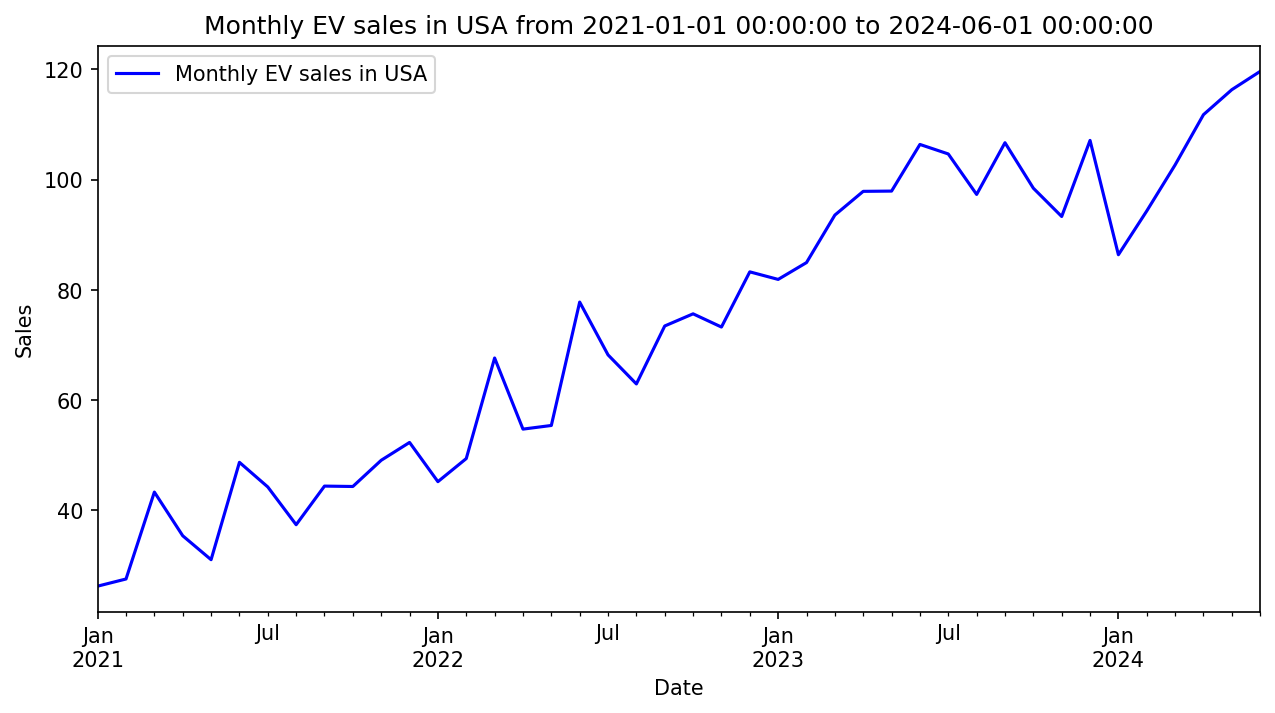

In [4]:
# Visualizing the series
plt.figure(figsize=(10, 5), dpi=150)
sales_df_group['Sales'].plot(label='Monthly EV sales in USA', color='blue')
plt.title('Monthly EV sales in USA from {} to {}'.format(sales_df_group.index[0], sales_df_group.index[-1]))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

In [5]:
test_periods = [['2022-07-01', '2022-12-01'],
                ['2023-01-01', '2023-06-01'],
                ['2023-07-01', '2023-12-01'],
                ['2024-01-01', '2024-06-01']]  # 3
test_periods = [['2022-05-01', '2022-12-01'],
                ['2023-01-01', '2023-08-01'],
                ['2023-09-01', '2024-04-01']]  # 4

In [6]:
def train_test(data, start, end, model_name, ifPlot):
    data = data[['Sales']]
    date_list = list(data.index)
    date_list = [datetime.datetime.strftime(date, '%Y-%m-%d')[:10] for date in date_list]
    index_s = date_list.index(start)
    index_e = date_list.index(end)
    train_data = data.iloc[:index_s]
    test_data = data.iloc[index_s:(index_e + 1)]
    print(test_data)
    model = None
    res_df = None
    name = None
    res = [list(test_data['Sales'])]
    if model_name == 'single':  # Single ETS
        model = SimpleExpSmoothing(train_data).fit()
        res_df = model.forecast(len(test_data))
        res.append(res_df.to_list())
        name = 'Single ETS'
    elif model_name == 'double add':  # Double ETS Additive
        model = ExponentialSmoothing(train_data, trend='add').fit()
        res_df = model.forecast(len(test_data))
        res.append(res_df.to_list())
        name = 'Double ETS Additive'
    elif model_name == 'double mul':  # Double ETS Multiplicative
        model = ExponentialSmoothing(train_data, trend='mul').fit()
        res_df = model.forecast(len(test_data))
        res.append(res_df.to_list())
        name = 'Double ETS Multiplicative'
    elif model_name == 'triple add':  # Triple ETS Additive
        model = ExponentialSmoothing(train_data, trend='add').fit()
        res_df = model.forecast(len(test_data))
        res.append(res_df.to_list())
        name = 'Triple ETS Additive'
    elif model_name == 'triple mul':  # Triple ETS Multiplicative
        model = ExponentialSmoothing(train_data, trend='mul').fit()
        res_df = model.forecast(len(test_data))
        res.append(res_df.to_list())
        name = 'Triple ETS Multiplicative'
    elif model_name == 'arima':  # ARIMA
        model = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         start_P=0, seasonal=True, m=3,
                         d=None, D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
        res_df = model.predict(n_periods=len(test_data), return_conf_int=False)
        res.append(res_df.to_list())
        name = 'ARIMA'
    if ifPlot:
        plt.figure(figsize=(10, 5), dpi=150)
        train_data['Sales'].plot(label='Train Data', color='blue')
        test_data['Sales'].plot(label='Test Data', color='orange')
        display(res)
        res_df.plot(label='Prediction Data', color='green')
        plt.title('Monthly EV sales in USA from {} to {}'.format(date_list[0], end))
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
    return res, model, name

In [7]:
def evaluate(res):
    y_true, y_pred = res
    metrics_dict = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }
    return metrics_dict

In [10]:
model_dict = {}
model_list = ['single', 'double add', 'double mul', 'triple add', 'triple mul', 'arima']
models = {}
color_list = plt.cm.viridis(np.linspace(0, 1, len(model_list)))
for model in model_list:
    print(f'Processing Model: {model}')
    if model not in model_dict.keys():
        model_dict[model] = []
        models[model] = {}
    for item in test_periods:
        start, end = item[0], item[1]
        print(f'Current Test Period: {start} ~ {end}')
        result = train_test(sales_df_group, start, end, model, False)
        model_dict[model].append(evaluate(result[0]))
        models[model][start] = result[1]
    print(f'Model Finished: {model}\n')

Processing Model: single
Current Test Period: 2022-05-01 ~ 2022-12-01
             Sales
2022-05-01  55.366
2022-06-01  77.758
2022-07-01  68.177
2022-08-01  62.904
2022-09-01  73.422
2022-10-01  75.626
2022-11-01  73.228
2022-12-01  83.244
Current Test Period: 2023-01-01 ~ 2023-08-01
              Sales
2023-01-01   81.873
2023-02-01   84.926
2023-03-01   93.546
2023-04-01   97.853
2023-05-01   97.900
2023-06-01  106.367
2023-07-01  104.640
2023-08-01   97.294
Current Test Period: 2023-09-01 ~ 2024-04-01
              Sales
2023-09-01  106.679
2023-10-01   98.427
2023-11-01   93.289
2023-12-01  107.097
2024-01-01   86.350
2024-02-01   94.291
2024-03-01  102.650
2024-04-01  111.766
Model Finished: single

Processing Model: double add
Current Test Period: 2022-05-01 ~ 2022-12-01
             Sales
2022-05-01  55.366
2022-06-01  77.758
2022-07-01  68.177
2022-08-01  62.904
2022-09-01  73.422
2022-10-01  75.626
2022-11-01  73.228
2022-12-01  83.244
Current Test Period: 2023-01-01 ~ 2023-0

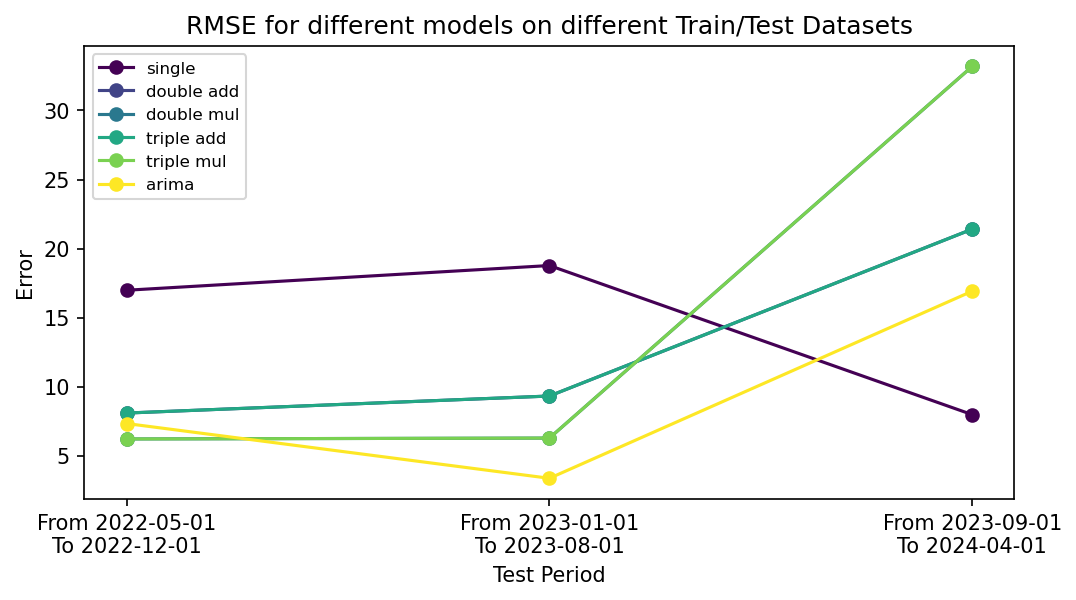

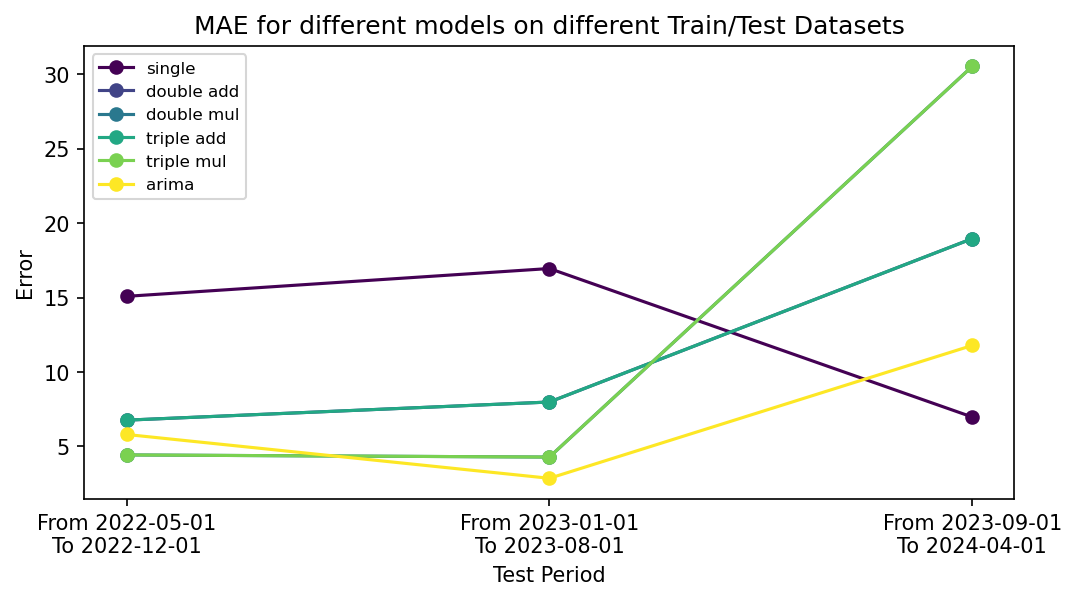

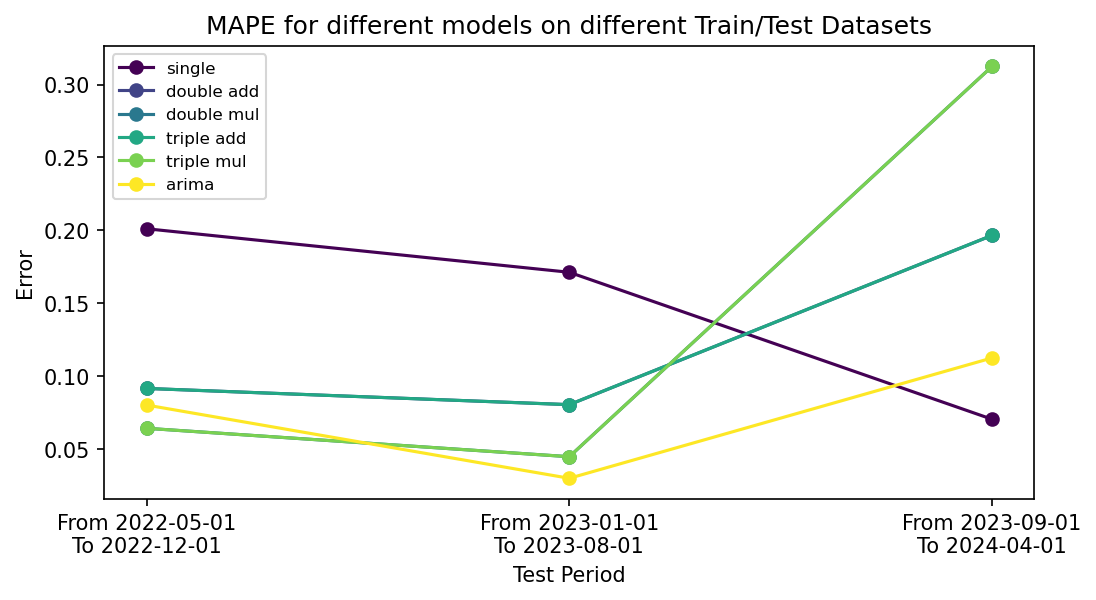

In [11]:
dates = ['From ' + item[0] + '\nTo ' + item[1] for item in test_periods]
for error in ['RMSE', 'MAE', 'MAPE']:
    plt.figure(figsize=(8, 4), dpi=150)
    for index, model in enumerate(model_list):
        temp = []
        for item in model_dict[model]:
            temp.append(item[error])
        plt.plot(dates, temp, color=color_list[index], marker='o', label=model)
    plt.legend(loc='best', prop={'size': 8})
    plt.ylabel('Error')
    plt.xlabel('Test Period')
    plt.title(f'{error} for different models on different Train/Test Datasets')

In [12]:
eval_df = pd.DataFrame(None)
index = []
for model in model_dict:
    index.append(model)
    result = []
    for metrics in ['RMSE', 'MAE', 'MAPE']:
        result.append(np.mean([item[metrics] for item in model_dict[model]]))
    eval_df = pd.concat([eval_df, pd.DataFrame(result).T], axis=0)
eval_df.columns = ['RMSE', 'MAE', 'MAPE']
eval_df.index = pd.Index(index)
eval_df.sort_values(by=['RMSE'], ascending=True)

,RMSE,MAE,MAPE
arima,9.193571,6.815664,0.074371
double add,12.931643,11.237829,0.122988
triple add,12.931643,11.237829,0.122988
single,14.570310,13.007896,0.147706
double mul,15.219248,13.083027,0.140575
triple mul,15.219248,13.083027,0.140575


              Sales
2023-01-01   81.873
2023-02-01   84.926
2023-03-01   93.546
2023-04-01   97.853
2023-05-01   97.900
2023-06-01  106.367
2023-07-01  104.640
2023-08-01   97.294
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[3]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=137.169, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=140.851, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[3]             : AIC=139.166, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[3]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[3]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[3]             : AIC=138.852, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[3]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[3] intercept   : AIC=139.169, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[3]          
Total fit time: 0.699 seconds


[[81.873, 84.926, 93.546, 97.853, 97.9, 106.367, 104.64, 97.294],
 [85.44799999999327,
  83.04999999999087,
  93.06599999999125,
  95.26999999998452,
  92.87199999998212,
  102.8879999999825,
  105.09199999997577,
  102.69399999997337]]

[[81.873, 84.926, 93.546, 97.853, 97.9, 106.367, 104.64, 97.294],
 [85.44799999999327,
  83.04999999999087,
  93.06599999999125,
  95.26999999998452,
  92.87199999998212,
  102.8879999999825,
  105.09199999997577,
  102.69399999997337]]

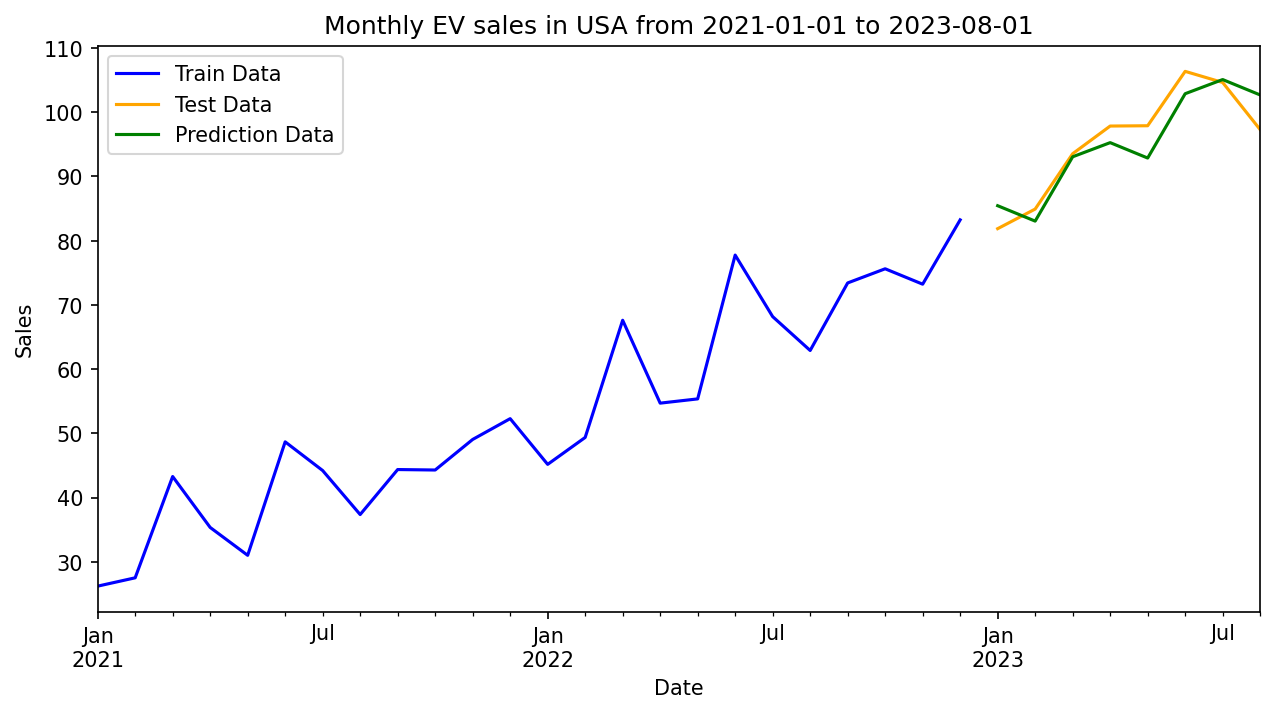

In [13]:
i = 1
res = train_test(sales_df_group, test_periods[i][0], test_periods[i][1], 'arima', True)
res[0]